In [ ]:
!pip install simglucose

In [ ]:
!pip install gym==0.17.3

In [ ]:
!pip uninstall tensorflow
!pip uninstall keras
!pip install tensorflow
!pip install keras

In [ ]:
from simglucose.simulation.user_interface import simulate
from simglucose.controller.base import Controller, Action
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.sim_engine import SimObj, sim, batch_sim
from simglucose.sensor.cgm import CGMSensor
from simglucose.actuator.pump import InsulinPump
from simglucose.simulation.env import T1DSimEnv
from simglucose.simulation.scenario_gen import RandomScenario

import gym

from datetime import timedelta, datetime

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

#Actor Critic Network
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import numpy



In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

In [ ]:
# If using TensorFlow's implementation of Keras
from keras import backend as ops

In [ ]:
class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, obs_size, act_size):
        super(ActorCriticNetwork, self).__init__()

        self.base = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(2,),trainable = True)
        ])

        self.mu = tf.keras.Sequential([
            tf.keras.layers.Dense(1,trainable = True),
            tf.keras.layers.Activation('relu')
        ])

        self.var = tf.keras.Sequential([
            tf.keras.layers.Dense(1,trainable = True),
            tf.keras.layers.Activation('softplus')
        ])

        self.value = tf.keras.layers.Dense(1)

    def call(self, inputs):
        state, time = inputs
        time = tf.constant(float(time), dtype=tf.float32)
        state = tf.constant(state, dtype=tf.float32)
        state = tf.reshape(state, (-1, 1))  # Ensure state has shape (batch_size, 1)
        time = tf.reshape(time, (-1, 1))
        input = tf.concat([state, time], axis=1)
        #print(input)
        base_out = self.base(input)
        return self.mu(base_out), self.var(base_out), self.value(base_out)


In [ ]:
import numpy as np
import math

In [ ]:


#Controller for RL
class RlController(Controller):
    def __init__(self, init_state):
        self.init_state = init_state
        self.state = init_state
        #actor critic network
        self.gamma = 0.999
        self.n_actions = 1 #only through basal
        self.action_space = [0, 30]
        self.actor_critic = ActorCriticNetwork(2,self.n_actions)
        self.optimizer = keras.optimizers.Adam(learning_rate=0.01,clipvalue=1.0)
        #buffer
        self.action_probs_history = []
        self.action_var_history = []
        self.critic_value_history = []
        self.rewards_history = []
        self.action_history = []
        self.eps = np.finfo(np.float32).eps.item()
        #loss
        self.huber_loss = tf.keras.losses.Huber()
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.entropy_coefficient = 1e-4
        self.eps = np.finfo(np.float32).eps.item()

    def choose_action(self, observation):
        mu_v, var_v, _ = self.actor_critic(observation)
        mu = mu_v.numpy()[0][0]
        sigma = tf.sqrt(var_v).numpy()[0][0]

        # Using TensorFlow's random.normal to generate random values
        action = tf.random.normal(shape=mu.shape, mean=mu, stddev=sigma)
        action = np.clip(action, 0, 15)
        action = round(action, 1)
        #print(action, mu, sigma)
        self.action = action
        return action

    def policy(self, observation, reward, done, **info):
        '''
        Every controller must have this implementation!
        ----
        Inputs:
        observation - a namedtuple defined in simglucose.simulation.env. For
                      now, it only has one entry: blood glucose level measured
                      by CGM sensor.
        reward      - current reward returned by environment
        done        - True, game over. False, game continues
        info        - additional information as key word arguments,
                      simglucose.simulation.env.T1DSimEnv returns patient_name
                      and sample_time
        ----
        Output:
        action - a namedtuple defined at the beginning of this file. The
                 controller action contains two entries: basal, bolus
        '''
        self.state = observation
        action = self.choose_action(observation)
        return Action(basal = action, bolus = 0.0)

    def learn(self, t, reward, state_, done):
        with tf.GradientTape() as tape:
          #reward+= 0.1* t
          #reward = tf.convert_to_tensor([reward], dtype=tf.float32)
          mu, var, value = self.actor_critic(state_)
          #print("MU:",mu)
          self.action_probs_history.append(ops.log(mu.numpy()[0][0]))
          self.action_var_history.append(ops.log(var.numpy()[0][0]))
          self.critic_value_history.append(value)
          self.rewards_history.append(reward)
          if done:
            #reward and advantage
            returns = []
            discounted_sum = 0
            for r in self.rewards_history[::-1]:
              discounted_sum = r + self.gamma * discounted_sum
              returns.insert(0, discounted_sum)
            # Normalize
            returns = np.array(returns)
            returns = (returns - np.mean(returns)) / (np.std(returns) + self.eps)
            returns = returns.tolist()
            history = zip(self.action_probs_history, self.action_var_history, self.critic_value_history, returns)
            actor_mu_losses = []
            actor_var_losses = []
            critic_losses = []
            for log_mu, log_var, value, ret in history:
              # Actor loss
              diff = ret - value
              actor_mu_losses.append(-log_mu * diff)

              # Actor variance loss (Entropy term)
              #actor_var_losses.append(-self.entropy_coefficient * (tf.math.log(2 * math.pi * log_var) + 1) / 2)
              log_var = tf.reshape(log_var, (1,))
              actor_var_losses.append(self.cross_entropy(tf.zeros_like(log_var),log_var))
              #print("Var ", log_var)

              # Critic loss (using Huber loss)
              critic_losses.append(self.huber_loss(value, ret))

            loss_value = sum(actor_mu_losses) + sum(actor_var_losses) + sum(critic_losses)
            grads = tape.gradient(loss_value, self.actor_critic.trainable_variables)
            #print(grads)
            self.optimizer.apply_gradients(zip(grads, self.actor_critic.trainable_weights))

          self.action_probs_history.clear()
          self.action_var_history.clear()
          self.critic_value_history.clear()
          self.rewards_history.clear()


    def reset(self):
        '''
        Reset the controller state to inital state, must be implemented
        '''
        self.state = self.init_state


ctrller = RlController(0)


In [ ]:
for var in ctrller.actor_critic.trainable_variables:
    print(var.name, var.trainable, var.numpy())

In [ ]:
#custom reward function

def custom_reward(BG_last_hour):
    glucose_future = BG_last_hour[-1]
    #print(glucose_future)
    if glucose_future > 70:
        if glucose_future < 180:
            return 1
        else:
            if glucose_future < 500:
                return -1
            else:
                return -100
    else:
        if glucose_future > 20:
            return -1
        else:
            return -100


In [ ]:
del gym.envs.registry.env_specs['InsulinEnv-v1']

In [ ]:
import warnings

# Désactiver le warning spécifique
warnings.simplefilter("ignore")


In [ ]:
RANDOM_SEED = 10
NUM_SCENARIOS = 10

start_time = datetime(2018, 1, 1, 0, 0, 0)
random_scenarios = [RandomScenario(start_time=start_time, seed=RANDOM_SEED + i) for i in range(NUM_SCENARIOS)]
patient_names = ['adolescent#001', 'adolescent#002', 'adolescent#003','adult#001','adult#002','adult#003']

patientID = 12
patient = T1DPatient.withID(12)

sim_sensor = CGMSensor.withName('Dexcom')

sim_pump = InsulinPump.withName('Insulet')

num_episodes = 100
max_steps_per_episode = 480
if 'InsulinEnv-v1' not in gym.envs.registry.env_specs:
  gym.register(id='InsulinEnv-v1', entry_point='simglucose.envs:T1DSimEnv', kwargs={'patient_name':patient_names,'reward_fun': custom_reward,'custom_scenario': random_scenarios})
env = gym.make('InsulinEnv-v1')




In [ ]:
obs = env.reset()
done = False
for i_episode in range(num_episodes):
    observation = env.reset()
    observation = (observation.CGM,env.env.time.hour)
    for t in range(max_steps_per_episode):
        action = ctrller.choose_action(observation)
        print(action)
        observation, reward, done, info = env.step(action)
        #print(action)
        observation = (observation.CGM,env.env.time.hour)
        #print(action)
        #print(reward)
        #print(env.env.time.minute)
        ctrller.learn(t, reward, observation, done)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

In [ ]:
observation = env.reset()
action = ctrller.choose_action((observation.CGM,env.env.time.hour))
print(action)

5.8


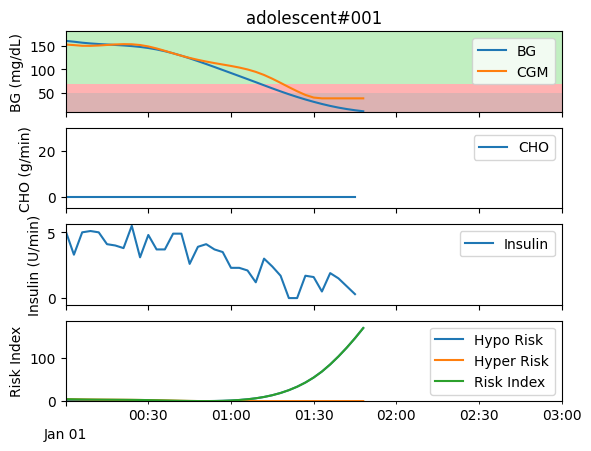

In [ ]:
observation = env.reset()
for t in range(200):
        action = ctrller.choose_action((observation.CGM,env.env.time.hour))
        old_obs = observation
        env.render(mode='human')
        observation, reward, done, info = env.step(action)
        #print(action)
        #print(reward)
        if done:
           break